#  XPCS   Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [1]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [2]:
hdr = db[{{ uid }}]

NameError: name 'uid' is not defined

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time
from ipywidgets import interact

In [3]:
cd /home/yuzhang/chx-pipelines/Develops/

/home/yuzhang/chx-pipelines/Develops


In [5]:
cd /XF11ID/analysis/Analysis_Pipelines/Develop/

/XF11ID/analysis/Analysis_Pipelines/Develop


In [5]:
%run develop.py
%run two_time.py

In [6]:
%matplotlib notebook
#%matplotlib inline

# Users put 
* uid for Bluesky Scan
* filename for acquiring data directly by EigerSofteare

In [7]:
BlueScan = True
DirectAcq = False
detector = 'eiger_4M_cam_img_image_lightfield'  #for 4M

# Users put uid here

In [10]:
if BlueScan:
    uid = '54614d43'
    #uid = '95782687'
    uid = '95782687'
    uid= 'ff9f20c0'
    uid='71720966'
    uid='1663d34a'
    uid = 'f505e052-3baa-47d4-bdc4-61c2eb1bcc7a'  #sid= 551, 1%PEG, 
    uid='ee6975a1-9161'   #1% wt PEG
    uid = 'ffe9d518'  # 10 mTorr 1sec/frame
else:
    uid = '/XF11ID/data/2015/11/23/d01ab510-3cf3-4719-bee3_795_master.h5' 

### Get data

In [13]:
if BlueScan:
    hdr = db[uid]
    ev, = get_events(  hdr, [detector] )
    imgs = ev['data'][detector]
else:    
    imgs =  Images(uid)
print (imgs)
Nimg=len(imgs)

hdf5 path = /XF11ID/data/2015/11/8/3f84f57d-79b7-4a10-8b51_5_master.h5
<Frames>
Length: 15000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


### Get data path

In [14]:
if BlueScan:
    from datetime import datetime
    dt = datetime.fromtimestamp(hdr['start'].time)
    path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
else:
    path ='/XF11ID/analysis/2015/11/23/' 
path

'/XF11ID/analysis/2015/11/8/'

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [15]:
imgs.md

{'beam_center_x': 840.0,
 'beam_center_y': 1830.0,
 'count_time': 1.0,
 'detector_distance': 4.8400002,
 'frame_time': 1.00001,
 'framerate': 0.99998998651994853,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [16]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4812.        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 1.0)

## load a mask
#### load the mask saved in the mask_pipeline

In [17]:
mask = np.load( path +  str(uid)+ "_mask.npy")


### Reverse the mask in y-direction due to the coordination difference between python and Eiger software 

In [18]:
maskr = mask[::-1,:]

## Plot the mask

<IPython.core.display.Javascript object>


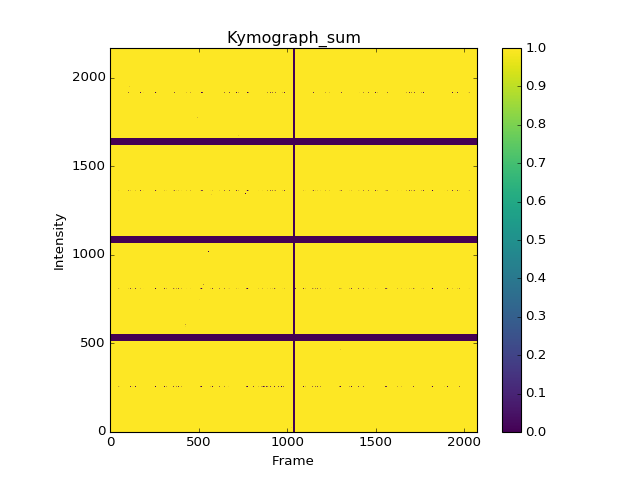

In [19]:
fig, ax = plt.subplots()
im=ax.imshow(maskr, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

In [20]:
def view_image(i):    
    fig, ax = plt.subplots()
    ax.imshow(imgs[i]*mask, interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm(vmin=0.001, vmax=1e1) )
    ax.set_title("Browse the Image Stack")
    plt.show()
    

In [21]:
#interact(view_image, i=(0, Nimg-1))

## Movie

In [22]:
def view_image(sleeps=1, ims=0, ime = 1):    
    fig, ax = plt.subplots()  
    for i in range( ims, ime  ):
        im=ax.imshow(imgs[i]*mask,  interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm( vmin=0.01, vmax=10 ) )
        ax.set_title("images_%s"%i)
        
        time.sleep( sleeps )
        plt.draw()
    #fig.colorbar(im)
        
#view_image(.2, 0, 2)

### hey, let's see if any images are bad!

#### load the image intensity (kymograph) saved in the mask_pipeline

In [23]:
kymo_sum = np.load( path +  str(uid)+"_kymo_sum.npy" ) 

In [24]:
bad_frames = np.where( kymo_sum > 1e5)[0]
bad_frames

array([ 1124,  1245,  4304,  6645,  7245, 12584, 13784])

<IPython.core.display.Javascript object>


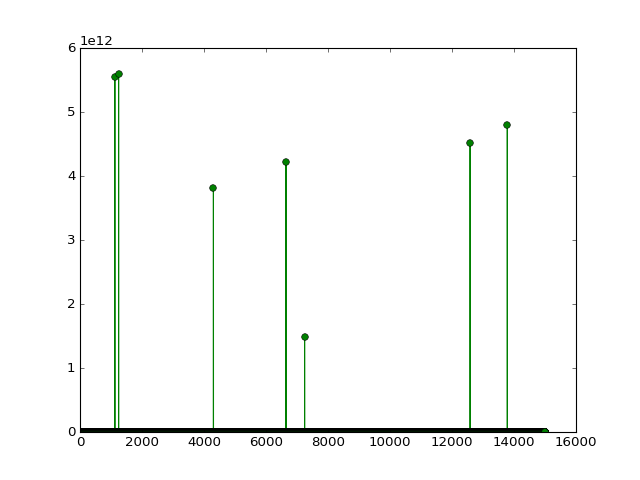

In [25]:
fig, axes = plt.subplots(  )
axes.plot( kymo_sum, '-go'  ) 
ax.set_ylabel('Intensity')
ax.set_xlabel('Frame')
ax.set_title('Kymograph_sum') 
plt.show()

### Get the Averaged Image Data

#### load the average intensity saved in the mask_pipeline

In [26]:
avg_img = np.load( path + str(uid)+"_avg_img.npy" )
avg_imgm =  avg_img * mask

### Reverse the image in y-direction due to the coordination difference between python and Eiger software 

In [27]:
avg_imgr  = avg_img[::-1,:] 
avg_imgmr  = avg_imgm[::-1,:] 

## Plot the averged image with the mask

<IPython.core.display.Javascript object>


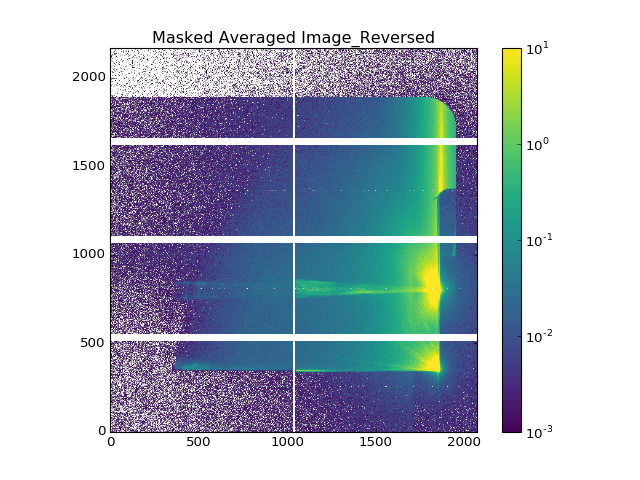

In [28]:
fig, ax = plt.subplots()
im = ax.imshow(avg_imgmr, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image_Reversed")
fig.colorbar(im)
plt.show()

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)


## Get the approximate center and see the statistic to make sure 

In [31]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4810        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 1.0)

## GiSAXS get q-map (qz and qr)

### Users put incident-Beam and Reflection_Beam Centers here!!!

In [32]:
inc_x0 = 1871
inc_y0 = 339
refl_x0 = 1871
refl_y0 = 811      #1670
Lsd= 4.81
lamda= lambda_  #12.4/9

In [33]:
lamda

1.3776

In [34]:
alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Lsd )

The incident_angle (alphai) is: 0.210835132612


In [35]:
qx, qy, qr, qz = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lamda, Lsd=Lsd )

The incident_angle (alphai) is: 0.210835132612


<IPython.core.display.Javascript object>


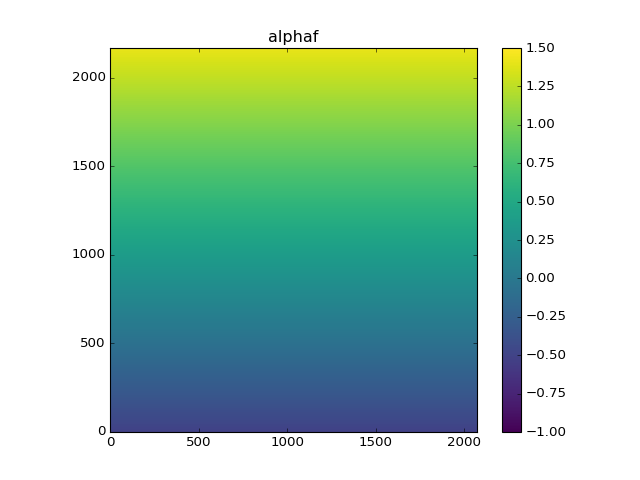

In [36]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(alphaf*180/np.pi, origin='lower' ,cmap='viridis',vmin=-1,vmax= 1.5 )
fig.colorbar(im)
ax.set_title( 'alphaf')
plt.show()

<IPython.core.display.Javascript object>


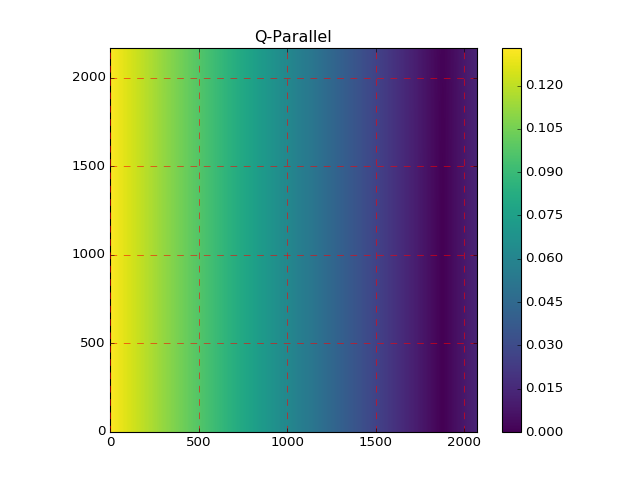

In [37]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(qr, origin='lower' ,cmap='viridis',vmin=qr.min(),vmax= qr.max(),) 
             #extent= [ qr.min(),qr.max(),qr.min(),qr.max()] )
fig.colorbar(im)
ax.set_title( 'Q-Parallel')
#ax.grid(True, which='both', color='r', linestyle='--')
ax.grid(True,  color='r', linestyle='--')
#ax.grid(True,color='white')

plt.show()

<IPython.core.display.Javascript object>


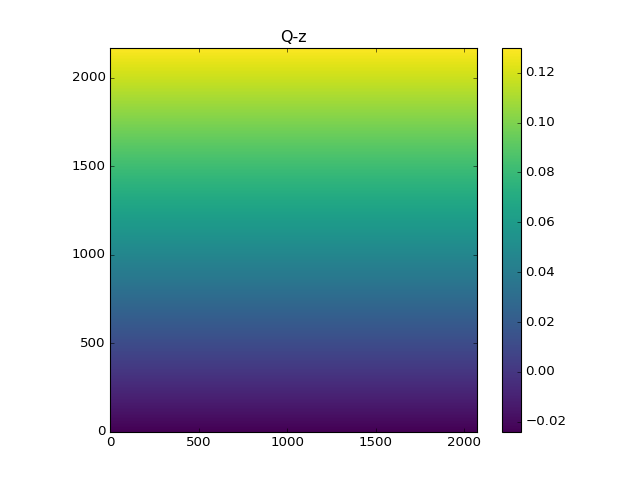

In [38]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(qz, origin='lower' ,cmap='viridis',vmin=qz.min(),vmax= qz.max() )
fig.colorbar(im)
ax.set_title( 'Q-z')
plt.show()

# Get q||-intensity

## Users put cuts here!!!

<IPython.core.display.Javascript object>


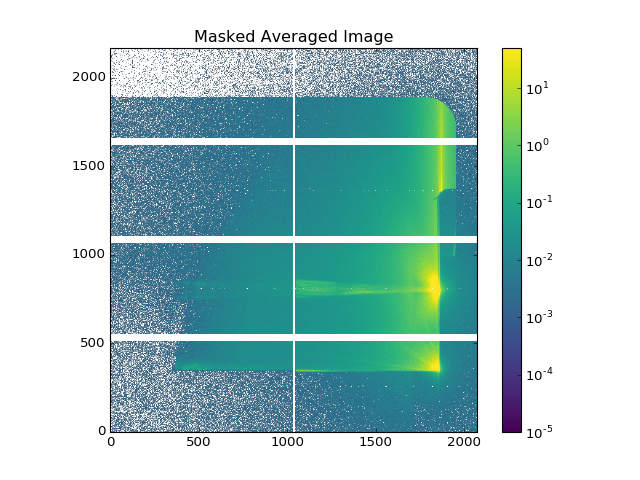

In [41]:
fig, ax = plt.subplots()
im = ax.imshow(avg_imgr, cmap='viridis', origin = 'lower',  norm= LogNorm( vmin=0.00001, vmax=.5e2 ) )
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

In [42]:
vert_rect = ( ( 850, 0, 980- 850, 1600-0) , ( 570, 0, 700- 570, 1600-0) )    #(y,x, hight, wdith)

In [43]:
new_mask = np.ones_like( avg_imgr)
new_mask[ :, 1020:1045] =0

<IPython.core.display.Javascript object>


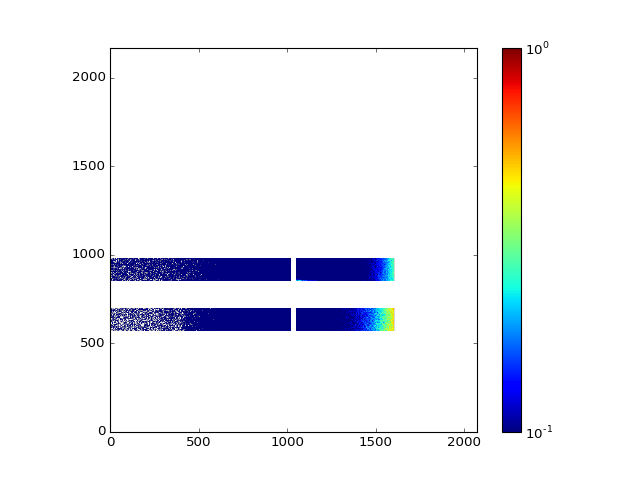

<IPython.core.display.Javascript object>


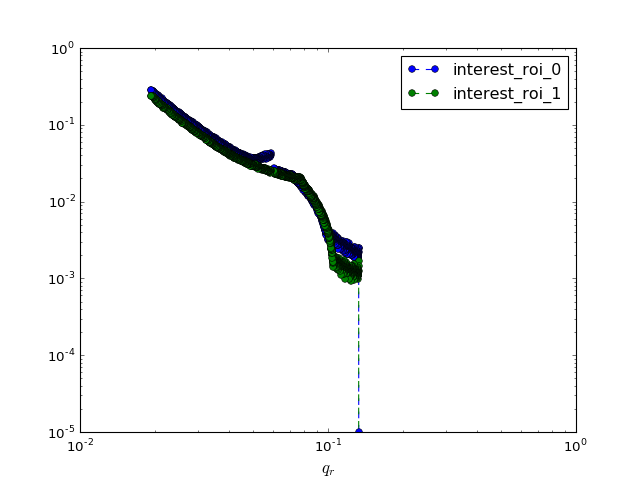

0 (850, 0, 130, 1600)
1 (570, 0, 130, 1600)


In [44]:
get_qr_intensity( qr, avg_imgr, vert_rect, mask=new_mask, show_roi=True)

## User gives the interested Qz,Qr here!!! 

In [45]:
qz_start = qz[670,0]
qz_end = qz[950,0]
qz_num= 2


qr_start =  qr[600,1700]
qr_end = qr[600,0]
qr_num = 15

## Create label array (Qz, Qr, Qzr boxes)

In [46]:
qr_edge, qr_center = get_qedge(qr_start , qr_end, ( qr_end- qr_start)/qr_num, qr_num )
qz_edge, qz_center = get_qedge( qz_start,   qz_end,   (qz_end - qz_start)/(qz_num -0) , qz_num )

label_array_qz = get_qmap_label( qz, qz_edge)
label_array_qr = get_qmap_label( qr, qr_edge)
label_array_qzr,qzc,qrc = get_qzrmap(label_array_qz, label_array_qr,qz_center, qr_center  )

labels_qzr, indices_qzr = roi.extract_label_indices( label_array_qzr  )
labels_qz, indices_qz = roi.extract_label_indices( label_array_qz  )
labels_qr, indices_qr = roi.extract_label_indices( label_array_qr  )

num_qz = len(np.unique( labels_qz ))
num_qr = len(np.unique( labels_qr ))
num_qzr = len(np.unique( labels_qzr ))

In [47]:
num_qz,num_qr,num_qzr

(2, 15, 30)

<IPython.core.display.Javascript object>


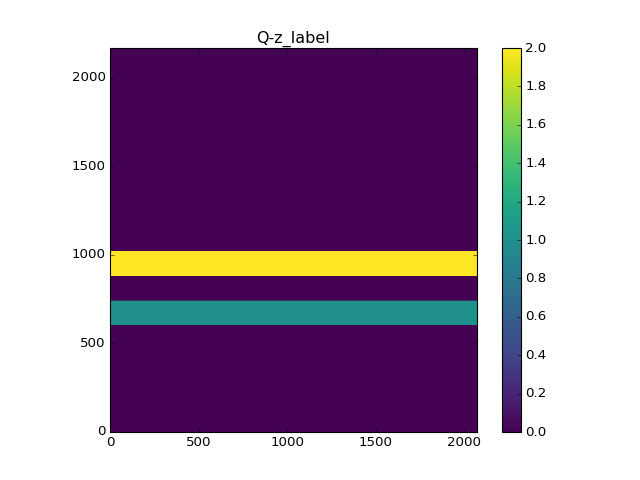

In [48]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(label_array_qz, origin='lower' ,cmap='viridis',vmin=0,vmax= None )
fig.colorbar(im)
ax.set_title( 'Q-z_label')
plt.show()

<IPython.core.display.Javascript object>


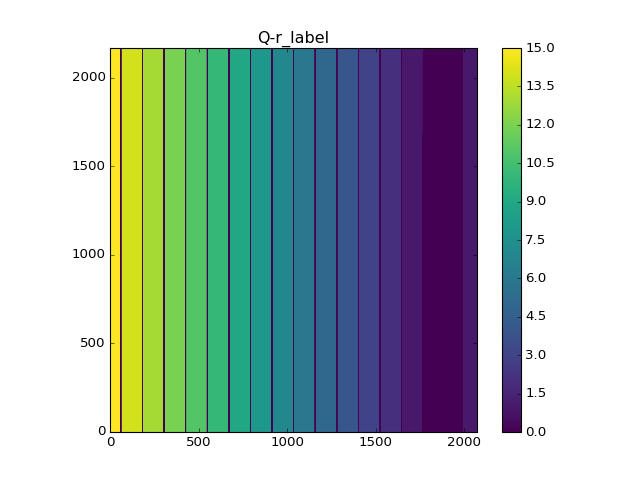

In [49]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(label_array_qr, origin='lower' ,cmap='viridis',vmin=0,vmax= None )
fig.colorbar(im)
ax.set_title( 'Q-r_label')
plt.show()

## Extract the labeled array

In [50]:
boxes = label_array_qzr 
box_maskr = boxes*maskr


In [51]:
qind, pixelist = roi.extract_label_indices(   box_maskr  )
noqs = len( np.unique(qind) )
nopr = np.bincount(qind, minlength=(noqs+1))[1:]

## Number of pixels in each q ring

In [52]:
nopr

array([27383, 15846, 15707, 15707, 15846, 15290, 15845, 15697, 15706,
       15846, 15703, 15843, 15707, 15846,  7922, 27776, 16074, 15933,
       15933, 16074, 15508, 16074, 15933, 15933, 16039, 15933, 16074,
       15933, 16074,  8037])

## plot average image with interested Q-regions (boxes)

<IPython.core.display.Javascript object>


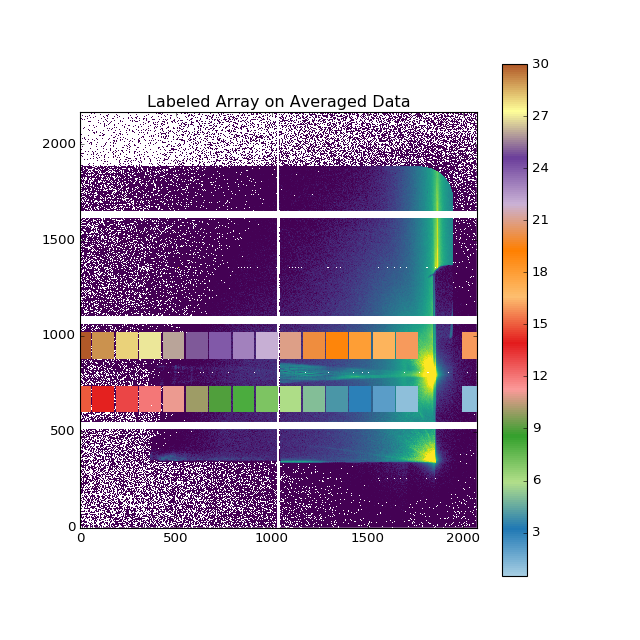

In [54]:
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array on Averaged Data")
im,im_label = show_label_array_on_image(axes, avg_imgr, box_maskr, imshow_cmap='viridis',
                        cmap='Paired',
                         vmin=0.01, vmax=30. ,  origin="lower")
#rwidth = 200 
#x1,x2 = [center[1] - rwidth, center[1] + rwidth]
#y1,y2 = [center[0] - rwidth, center[0] + rwidth]
#axes.set_xlim( [x1,x2])
#axes.set_ylim( [y1,y2])

#fig.colorbar(im)
fig.colorbar(im_label)
plt.show()

##  Kymograph(waterfall plot) of the max-intensity ring

In [55]:
imgs_ =imgs
imgsr = Reverse_Coordinate(imgs_, maskr)    

In [56]:
t0 = time.time()
data_pixel =   Get_Pixel_Array( imgsr, pixelist).get_data()
run_time(t0)

Total time: 4.76 min


### users put the number of ring with max intensity here

In [57]:
max_inten_ring =2

In [58]:
pixelist_qi =  np.where( qind == max_inten_ring )[0]         
data_pixel_qi = data_pixel[:,pixelist_qi] 

In [59]:
data_pixel_qi.shape

(15000, 15846)

<IPython.core.display.Javascript object>


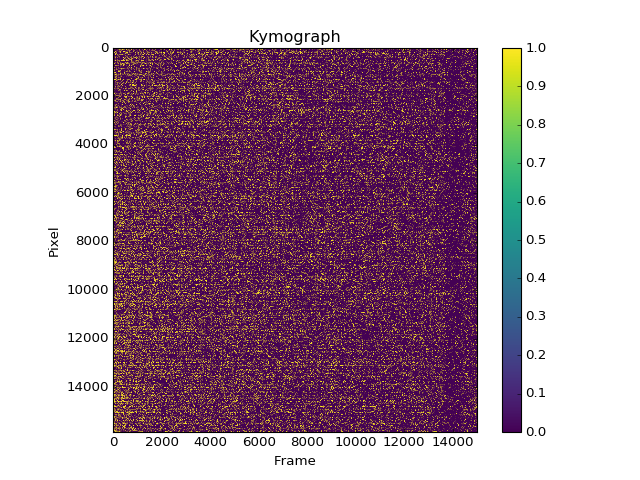

In [60]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph')

im = ax.imshow(data_pixel_qi.T, cmap='viridis', vmax=1.0)
fig.colorbar( im   )
ax.set_aspect(1.)
plt.show()

<IPython.core.display.Javascript object>


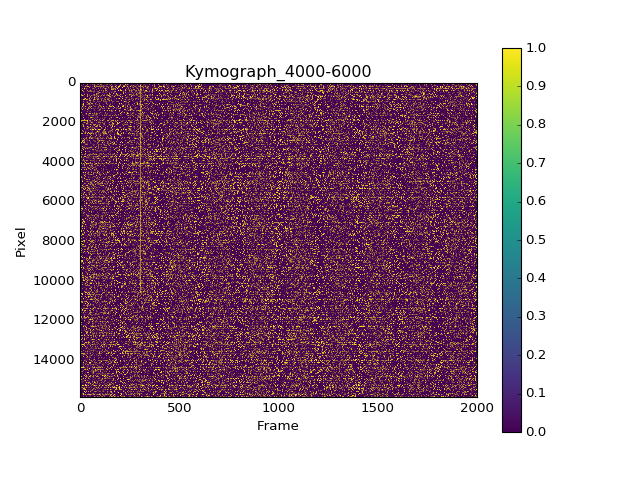

In [61]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph_4000-6000')

im = ax.imshow(data_pixel_qi[4000:6000,:].T, cmap='viridis', vmax=1.0)
fig.colorbar( im   )
ax.set_aspect(.1)
plt.show()

## TIme~Mean intensities for each ring

In [62]:
mean_inten = get_mean_intensity( data_pixel, qind)

<IPython.core.display.Javascript object>


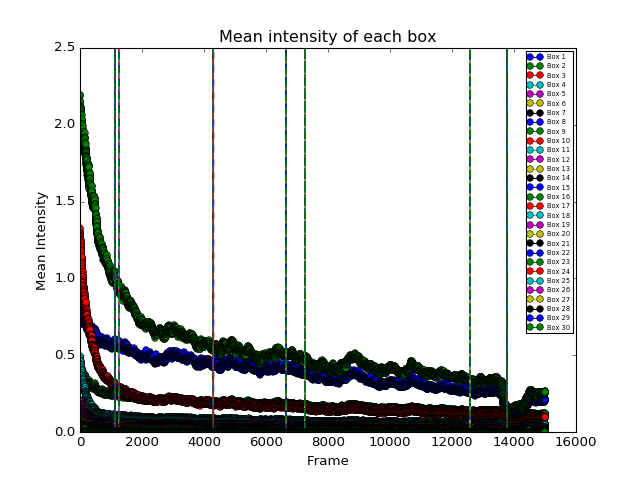

In [63]:
times = np.arange(  mean_inten[1].shape[0]   )  #*timeperframe  # get the time for each frame

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Mean intensity of each box")
for i in range(  num_qzr  ):
    ax.plot(times, mean_inten[i+1], '--o', label="Box "+str(i+1))
    ax.set_xlabel("Frame")
    ax.set_ylabel("Mean Intensity")
    ax.set_ylim(0, 2.5)
    
ax.legend( loc='best', fontsize = 6) 
plt.show()

##  Mean intensities for each ring

In [127]:
mask_data =   np.arange( len(data_pixel))  
mask_data_ = np.delete( mask_data, bad_frames)

In [336]:
#mask_data_

In [339]:
#mean_inten[1][:1000].mean()

In [177]:
K_mean = np.array( [mean_inten[i][mask_data_].mean() for i in  list(mean_inten.keys() )] )

In [178]:
K_mean

array([ 0.38237303,  0.17652289,  0.07161423,  0.04151951,  0.02951739,
        0.02423144,  0.02106524,  0.01891659,  0.01369414,  0.00836156,
        0.00419829,  0.00148836,  0.00123779,  0.00108712,  0.00100988,
        0.54096959,  0.18492724,  0.07727767,  0.04464761,  0.03106574,
        0.02452395,  0.02038103,  0.01715325,  0.0119164 ,  0.00718459,
        0.00355898,  0.00271693,  0.00226033,  0.00190928,  0.00168969])

## XSVS analysis

#### Get max count number

In [130]:
max_cts = data_pixel[mask_data_].max()
max_cts

1180.0

In [224]:
data_pixel[1000].max()

23.0

In [225]:
max_cts =60

In [235]:
data_pixel.shape

(15000, 483222)

In [66]:
#max_cts = data_pixel.max()
#max_cts

4294967295.0

In [262]:
%run speckle.py

### Users provide frame info (start-frame and end-frame) for analysis

In [316]:
good_start = 0
good_end =  3000# if using Nimg, then calculate all the images

good_end =    Nimg  #hen calculate all the images
imgs_ =imgs[good_start: good_end]
imgsr = Reverse_Coordinate(imgs_, mask) 

In [317]:
len(imgs_)

15000

In [319]:
time_steps = utils.geometric_series(2,   len(imgs_)   ) [:-3]
time_steps

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [320]:
num_times = len(time_steps)

In [321]:
spe_cts_all, std_dev = xsvs( (imgsr,), np.int_(box_maskr), timebin_num=2,
        number_of_img= len(imgs_), max_cts=int(max_cts+2), time_bin = time_steps,
                            bad_images=None, threshold = 5000 )

#bad image: 1124 here!
bad image: 1245 here!
##bad image: 4304 here!
##bad image: 6645 here!
bad image: 7245 here!
####bad image: 12584 here!
#bad image: 13784 here!
Total time: 34.25 min


In [323]:
spe_cts_all.shape

(11, 30)

In [324]:
#np.save( path + 'uid_%s_spe_cts_all'%uid, spe_cts_all)

In [148]:

#spe_cts_all = np.load(path + 'uid_%s_spe_cts_all.npy'%uid )

### This will provide the normalized bin edges for each integration time

In [ ]:
#Knorm_bin_edges, Knorm_bin_centers = speckle.normalize_bin_edges( len(time_steps), num_rings, K_mean, int(max_cts+2))

In [325]:
bin_edges, bin_centers, Knorm_bin_edges, Knorm_bin_centers = get_bin_edges(
      len(time_steps), num_qzr, K_mean, int(max_cts+2)  )

### Plot the results for each q box

<IPython.core.display.Javascript object>


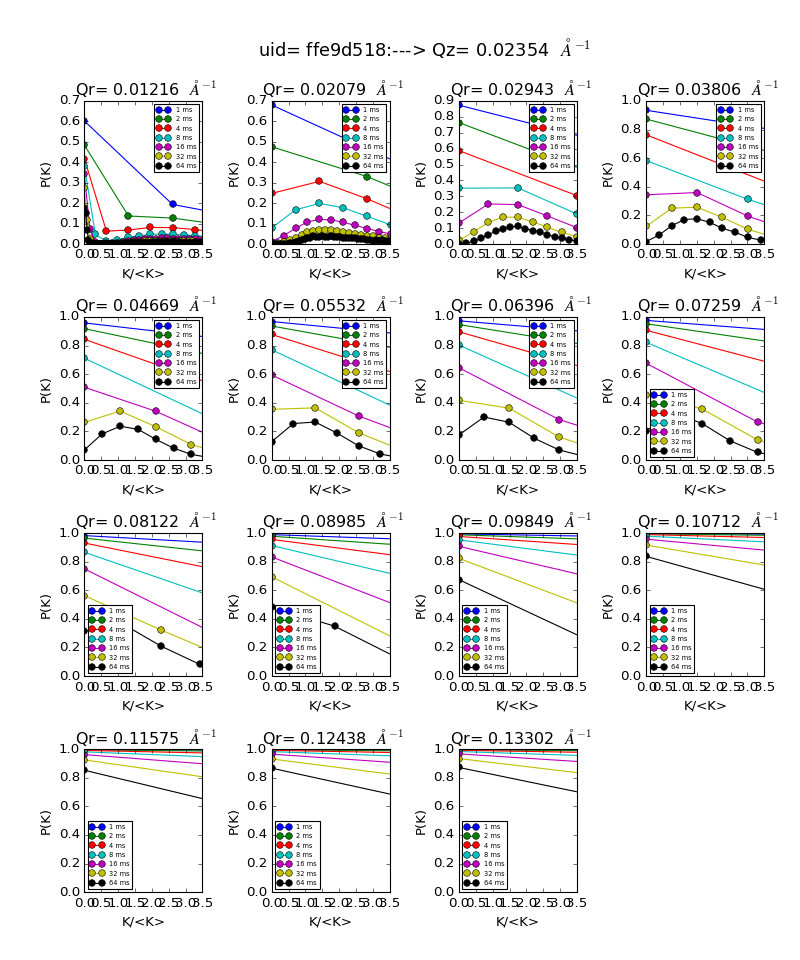

<IPython.core.display.Javascript object>


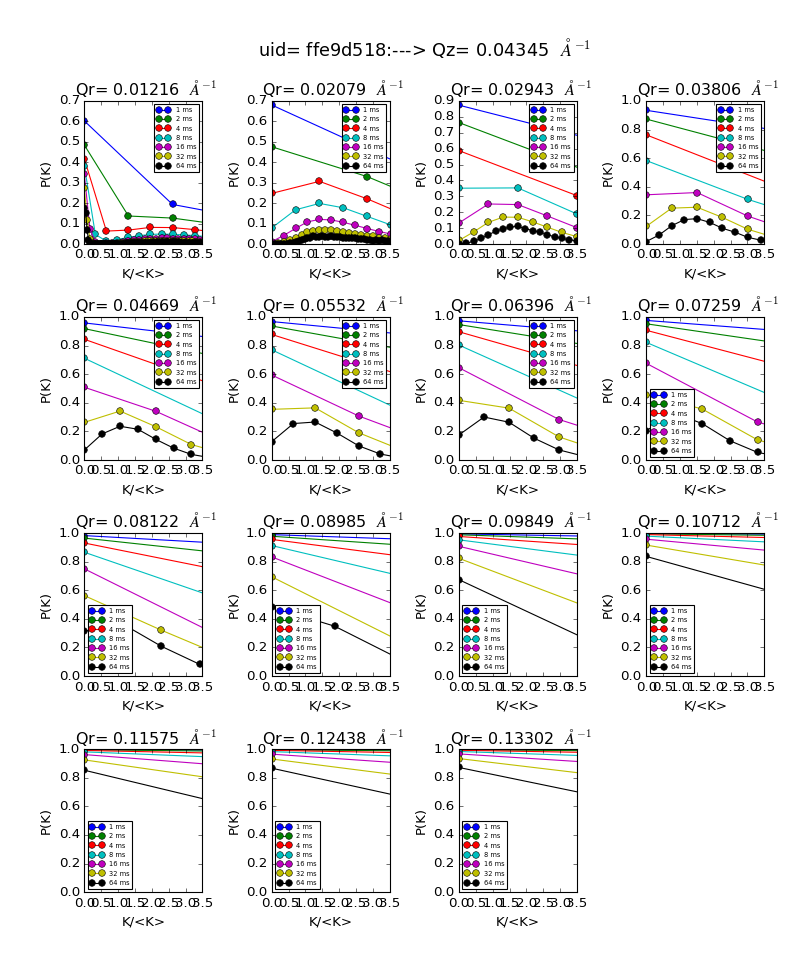

In [181]:
for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10,12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        axes = fig.add_subplot(sx,sy,sn+1 )        
        for j in range(len(time_steps)): 
            #if sn == 0:
            art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',
                     label=str(time_steps[j])+" ms")
            #else:
                #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',)             
            
        axes.set_xlim(0, 3.5)         
        axes.legend(loc='best', fontsize = 6)
        
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")  
 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        axes.set_title( title  )

    fig.tight_layout()  



### show one q plot

<IPython.core.display.Javascript object>


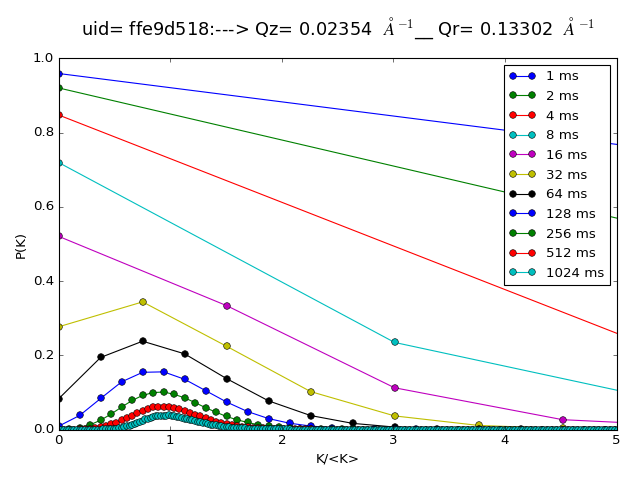

In [326]:
qz_ind =0
sn =3

fig = plt.figure(figsize=(8,6))
title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
#plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
axes = fig.add_subplot(111 ) 

for j in range(len(time_steps)): 
    art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',
                     label=str(time_steps[j])+" ms")
            #else:
                #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',)             
            
    axes.set_xlim(0, 5.0)         
    axes.legend(loc='best', fontsize = 12)
        
    axes.set_xlabel("K/<K>")
    axes.set_ylabel("P(K)")    

    title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
    axes.set_title( title,fontsize=16, y =1.05) 

fig.tight_layout()  

## Fit XSVS results

## Negative Binomaial Distribution
$P(K) =(\frac{M}{<K>})^M \frac{K ^(M-1)}{\Gamma(M)}\exp(-M\frac{K}{<K>})$
             

## Gamma Distribution

$P(K)=\frac{\Gamma(K+M)}{\Gamma(K+1)\Gamma(M)}(\frac{M}{M+<K>})^M(\frac{<K>}{M+<K>})^K$

## Poission Distribution
$P(K) = \frac{<K>^K}{K!}\exp(-<K>)$

### Fitting with Negative Binomial and Gamma and Poisson Distribution

In [269]:
%run speckle.py

In [270]:
from lmfit import  Model
from scipy.interpolate import UnivariateSpline

g_mod = Model(gamma_dist, indepdent_vars=['K'])
#g_mod = Model( gamma_dist )
n_mod = Model(nbinom_dist)
p_mod = Model(poisson_dist)
dc_mod = Model(diff_mot_con_factor)

In [271]:
#gamma_dist??

## This will provide the better range to fit

In [202]:
def get_roi(data, threshold=1e-3):
    roi = np.where(data>threshold)
    if len(roi[0]) > len(data)-2:
        roi = (np.array(roi[0][:-2]),)                    
    elif len(roi[0]) < 2:
        roi = np.where(data>=0)
    return roi[0]
        

In [207]:
#get_roi(data=spe_cts_all[0,3], threshold=1e-8)

array([0, 1, 2, 3, 4])

## fit with Negative Binomial Function

In [217]:
#Knorm_bin_edges[0,0][:100]

In [305]:
K_mean

array([ 0.38237303,  0.17652289,  0.07161423,  0.04151951,  0.02951739,
        0.02423144,  0.02106524,  0.01891659,  0.01369414,  0.00836156,
        0.00419829,  0.00148836,  0.00123779,  0.00108712,  0.00100988,
        0.54096959,  0.18492724,  0.07727767,  0.04464761,  0.03106574,
        0.02452395,  0.02038103,  0.01715325,  0.0119164 ,  0.00718459,
        0.00355898,  0.00271693,  0.00226033,  0.00190928,  0.00168969])

In [306]:
K_mean.shape

(30,)

In [330]:
bin_edges[0,3]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

In [331]:
Knorm_bin_edges[0,3][:10]

array([   0.        ,   24.08506297,   48.17012594,   72.25518891,
         96.34025187,  120.42531484,  144.51037781,  168.59544078,
        192.68050375,  216.76556672])

In [329]:
K_mean[3]

0.041519509469436791

<IPython.core.display.Javascript object>


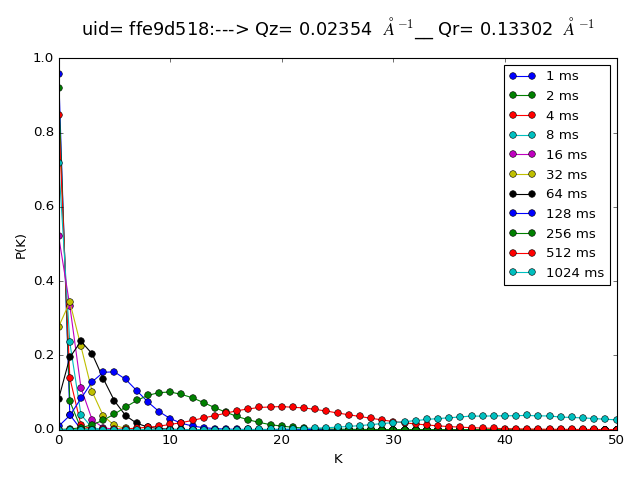

In [334]:
qz_ind =0
sn =3

fig = plt.figure(figsize=(8,6))
title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
#plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
axes = fig.add_subplot(111 ) 

for j in range(len(time_steps)): 
    art, = axes.plot(bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',
                     label=str(time_steps[j])+" ms")
            #else:
                #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',)             
            
    axes.set_xlim(0, 50.0)         
    axes.legend(loc='best', fontsize = 12)
        
    axes.set_xlabel("K")
    axes.set_ylabel("P(K)")    

    title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
    axes.set_title( title,fontsize=16, y =1.05) 

fig.tight_layout() 

<IPython.core.display.Javascript object>


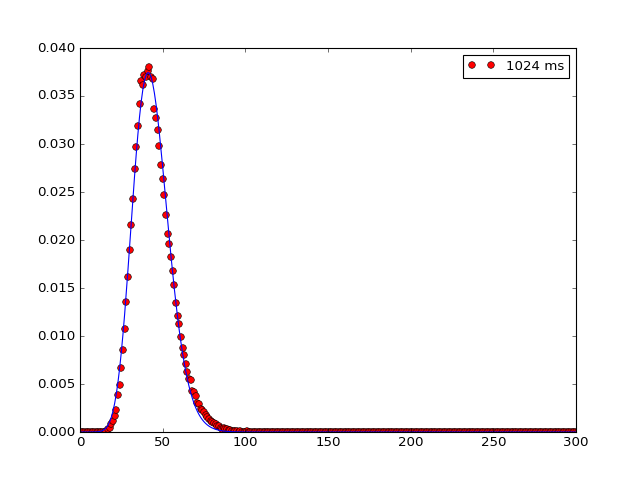

14529.4136936 0.0414693890024
82381.3102107 0.0828065995763
20.275901528 0.16605024892
19.1165442292 0.332074789667
18.876566258 0.663986595277
19.1598184631 1.32721422114
19.0917230463 2.65203654088
19.4390513842 5.29920004004
19.7940405232 10.645961091
19.7587704903 21.2878523726
25.5695322035 43.4642194427
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90
 91 92 93 97] 25.5695322035 43.4642194427


/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/axes/_axes.py:522: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [363]:
qz_ind =0
sn =3

fig = plt.figure(figsize=(8,6))
title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
#plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
axes = fig.add_subplot(111 ) 

for j in range(len(time_steps)): 
    roi = get_roi(data=spe_cts_all[j, sn], threshold=1e-4)  
    #print (roi)
    
    result_n = n_mod.fit(spe_cts_all[j, sn][roi],
            bin_values=bin_edges[j, sn][:-1][roi], K=K_mean[j] * 2**j, M=100)
    M_val=result_n.best_values['M']
    K_val=result_n.best_values['K']
    print (M_val,K_val)
    x=bin_edges[j, sn][:-1]
    fx = nbinom_dist(  x, K_val, M_val )
    if j ==10:
        print (roi, M_val, K_val)
        art, = axes.plot(x, spe_cts_all[j, sn], 'or',label=str(time_steps[j])+" ms")
        art, = axes.plot(  x ,fx, '-b' )
    axes.set_xlim(0, 300)         
    axes.legend(loc='best', fontsize = 12)

In [350]:
x

array([    0,     1,     2, ..., 63484, 63485, 63486])

<IPython.core.display.Javascript object>


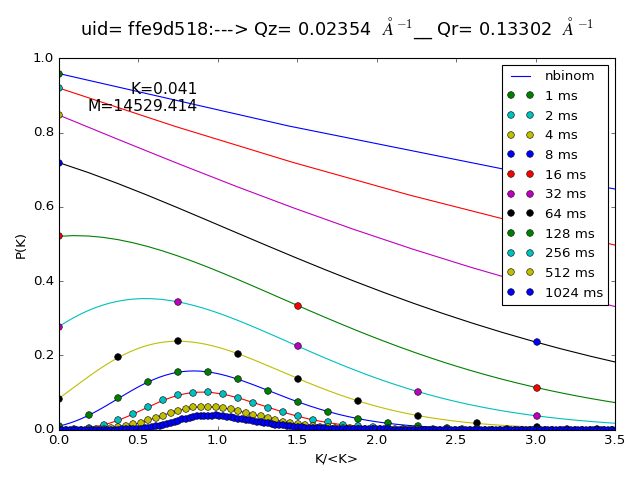

14529.4136936 0.0414693890024
82381.3102107 0.0828065995763
20.275901528 0.16605024892
19.1165442292 0.332074789667
18.876566258 0.663986595277
19.1598184631 1.32721422114
19.0917230463 2.65203654088
19.4390513842 5.29920004004
19.7940405232 10.645961091
19.7587704903 21.2878523726
25.5695322035 43.4642194427


In [362]:
qz_ind =0
sn =3

fig = plt.figure(figsize=(8,6))
title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
#plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
axes = fig.add_subplot(111 ) 

for j in range(len(time_steps)): 
    roi = get_roi(data=spe_cts_all[j, sn], threshold=1e-4)  
    #print (roi)
    
    result_n = n_mod.fit(spe_cts_all[j, sn][roi],
            bin_values=bin_edges[j, sn][:-1][roi], K=K_mean[j] * 2**j, M=100)
    M_val=result_n.best_values['M']
    K_val=result_n.best_values['K']
    print (M_val,K_val)
    
    #  Using the best K and M values interpolate and get more values for fitting curve
    #if j<=3:population_N = 10000
    #else:population_N=len(Knorm_bin_edges[j, sn][:-1])
    population_N  = 1000*2**j    
    fitx_ = np.linspace(0, max(Knorm_bin_edges[j, sn][:-1]), population_N     )   
    fitx = np.linspace(0, max(bin_edges[j, sn][:-1]), population_N )         
    fity = nbinom_dist( fitx, K_val, M_val ) # M and K are fitted best values
    if j == 0:
        art, = axes.plot( fitx_,fity, '-',  label="nbinom")
    else:
        art, = axes.plot( fitx_,fity, '-')                
                
    art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',
                     label=str(time_steps[j])+" ms")
            #else:
                #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',)             
            
    axes.set_xlim(0, 3.50)         
    axes.legend(loc='best', fontsize = 12)
   
    if j==0:axes.annotate(r'K='+'%.3f\n'%( K_val) +r'M='+'%.3f'%(M_val),
                      xy=(.25, 0.85),
                      xycoords='axes fraction', fontsize=14,
                      horizontalalignment='right', verticalalignment='bottom')
    axes.set_xlabel("K/<K>")
    axes.set_ylabel("P(K)")    

    title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
    axes.set_title( title,fontsize=16, y =1.05) 

fig.tight_layout() 

<IPython.core.display.Javascript object>


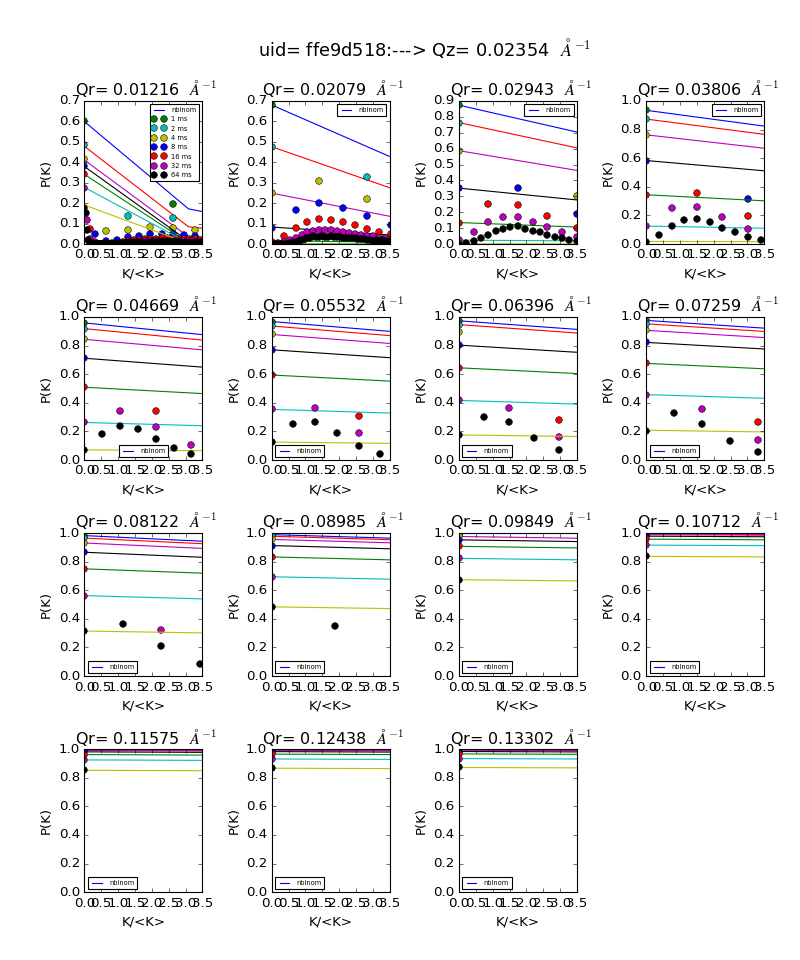

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


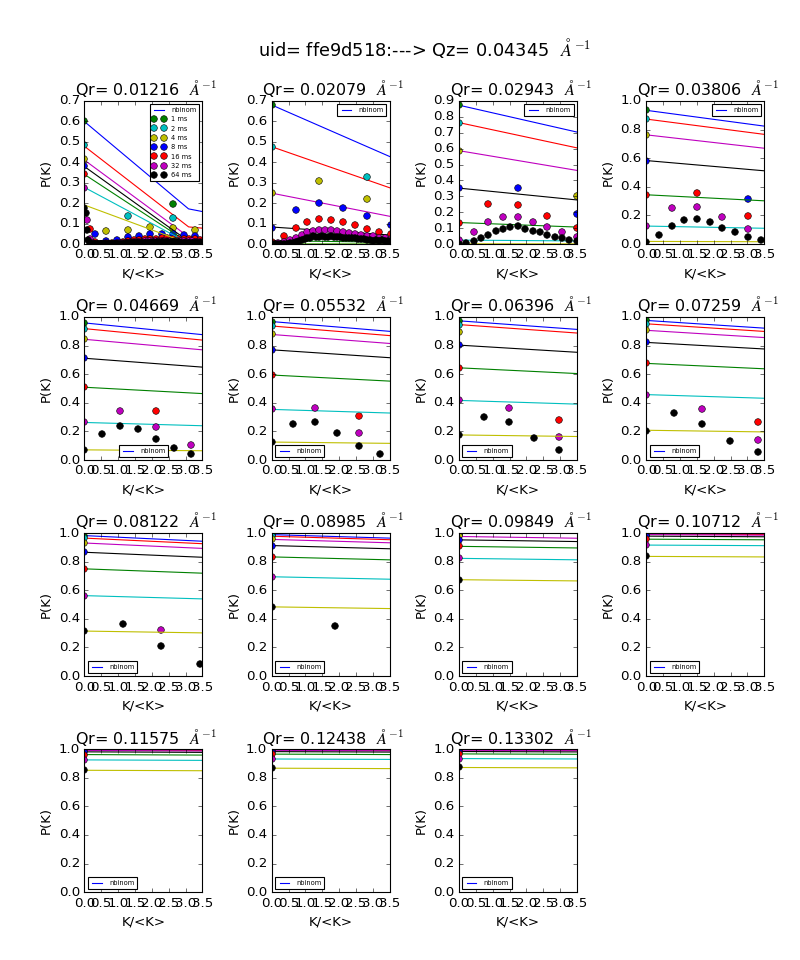

In [195]:
M_val = {}
K_val = {}

for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10,12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        axes = fig.add_subplot(sx,sy,sn+1 ) 
        M_val[sn]=[]
        K_val[sn]=[]
        for j in range(len(time_steps)): 
            
            result_n = n_mod.fit(spe_cts_all[j, sn],
                             bin_values=bin_edges[j, sn][:-1],
                             K=5 * 2**j, M=12)
            M_val[sn].append(result_n.best_values['M'])
            K_val[sn].append(result_n.best_values['K'])
         
            #  Using the best K and M values interpolate and get more values for fitting curve
            fitx_ = np.linspace(0, max(Knorm_bin_edges[j, sn][:-1]), 1000     )   
            fitx = np.linspace(0, max(bin_edges[j, sn][:-1]), 1000  )         
            fity = nbinom_dist( fitx, K_val[sn][j], M_val[sn][j] ) # M and K are fitted best values

        
            if j == 0:
                art, = axes.plot( fitx_,fity, '-',  label="nbinom")
            else:
                art, = axes.plot( fitx_,fity, '-')
        
        
        
            if sn == 0:
                art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',
                     label=str(time_steps[j])+" ms")
            else:
                art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',)             
            
        axes.set_xlim(0, 3.5)         
        axes.legend(loc='best', fontsize = 6)
        
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")  
 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        axes.set_title( title  )

    fig.tight_layout()  


In [196]:
plt.close('all')

<IPython.core.display.Javascript object>


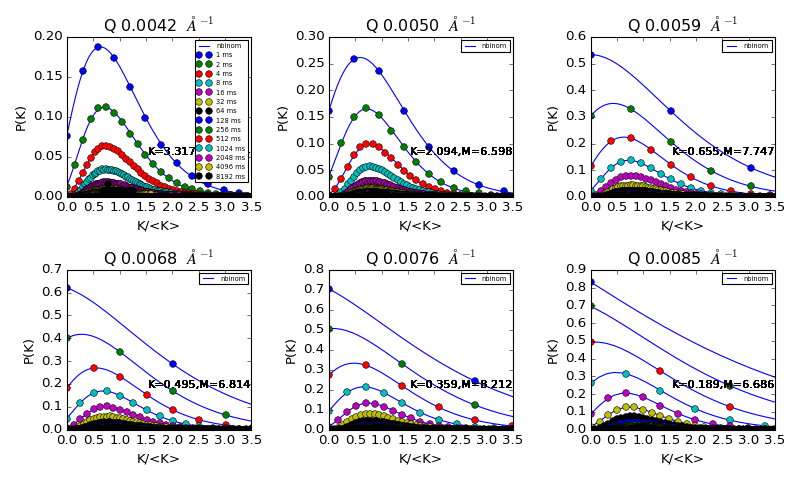

In [85]:
M_val = {}
K_val = {}
sx = int(round(np.sqrt(num_rings)))
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
fig = plt.figure(figsize=(10, 6))
plt.title('uid= %s'%uid+" Fitting with Negative Binomial Function", fontsize=20, y=1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    M_val[i]=[]
    K_val[i]=[]
    for j in range(   num_times  ):
        # find the best values for K and M from fitting
        result_n = n_mod.fit(spe_cts_all[j, i],
                             bin_values=bin_edges[j, i][:-1],
                             K=5 * 2**j, M=12)
        M_val[i].append(result_n.best_values['M'])
        K_val[i].append(result_n.best_values['K'])
        axes = fig.add_subplot(sx, sy, i+1 )
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")
        
        #  Using the best K and M values interpolate and get more values for fitting curve
        fitx_ = np.linspace(0, max(Knorm_bin_edges[j, i][:-1]), 1000     )   
        
        fitx = np.linspace(0, max(bin_edges[j, i][:-1]), 1000  )         
        fity = nbinom_dist( fitx, K_val[i][j], M_val[i][j] ) # M and K are fitted best values

        
        if j == 0:
            art, = axes.plot( fitx_,fity, '-b',  label="nbinom")
        else:
            art, = axes.plot( fitx_,fity, '-b')
        
                    
        if i==0:    
            art, = axes.plot( Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], 'o',
                     label=str(time_steps[j])+" ms")
        else:
            art, = axes.plot( Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], 'o',
                     )

        
        axes.set_xlim(0, 3.5)
        # Annotate the best K and M values on the plot
        axes.annotate(r'K='+'%.3f'%( K_val[i][0]) +','+r'M='+'%.3f'%(M_val[i][0]),
                      xy=(1, 0.25),
                      xycoords='axes fraction', fontsize=10,
                      horizontalalignment='right', verticalalignment='bottom')
        axes.set_title("Q "+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend(loc='best', fontsize = 6)
plt.show()
fig.tight_layout()  

In [75]:
[K_val[i][0] for i in range(num_rings)]

[3.3165319464701533,
 2.0941134953236222,
 0.65487867458291715,
 0.49482226403256657,
 0.35853928147592601,
 0.18873607742325987]

In [84]:
#[K_val[i][3] for i in range(num_rings)]

In [76]:
K_mean

array([ 3.36094063,  2.10911154,  0.65901917,  0.49677616,  0.3595105 ,
        0.18890328])

## This will provide the better range to fit

In [116]:
def get_roi(data, threshold=1e-3):
    roi = np.where(data>threshold)
    if len(roi[0]) > len(data)-2:
        roi = (np.array(roi[0][:-2]),)                    
    elif len(roi[0]) < 2:
        roi = np.where(data>=0)
    return roi[0]
        
    

In [111]:
roi = get_roi(data=spe_cts_all[j, i], threshold=1e-3)

### Fit with Gamma Distribution

<IPython.core.display.Javascript object>


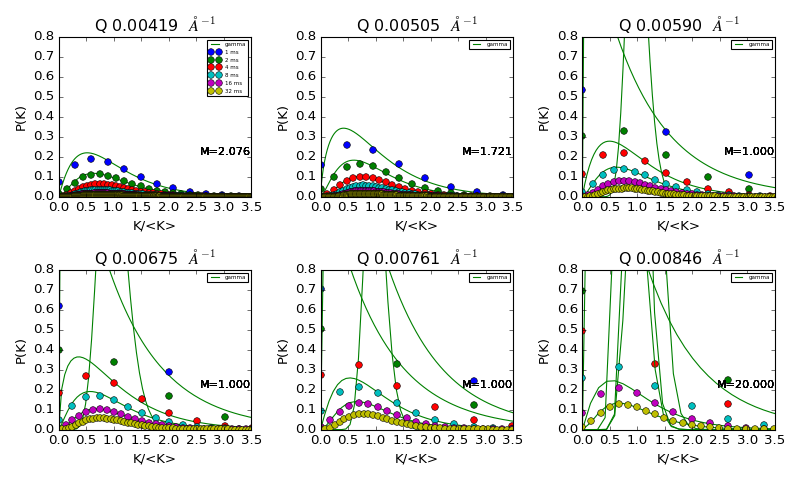

In [120]:

Mg_val = {}
fig = plt.figure(figsize=(10, 6))
plt.title('uid= %s'%uid+ " Fitting with Gamma Function", fontsize=20, y=1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

for i in range(num_rings):
    Mg_val[i] = []
    for j in range( 0, 6  ):        
        roi = get_roi(data=spe_cts_all[j, i], threshold=1e-7)  
        
        # find the best value for M from fitting     
        result_g = g_mod.fit(spe_cts_all[j, i][roi] ,
                             bin_values=bin_edges[j, i][:-1][roi] ,
                             K=K_mean[i]*2**j,  M= 20 )
        
        
        Mg_val[i].append(result_g.best_values['M'])
        axes = fig.add_subplot(sx, sy, i+1 )
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")
        
        #  Using the best M value interpolate and get more values for fitting curve
        fitx_ = np.linspace(0, max(Knorm_bin_edges[j, i][:-1]), 1000   )
        
        fitx = np.linspace(0, max(bin_edges[j, i][:-1]), 1000   )         
        fity = gamma_dist( fitx, K_mean[i]*2**j,  Mg_val[i][j] )

        
        if j == 0:
            art, = axes.plot( fitx_,fity, '-g',label="gamma") 
        else:
            art, = axes.plot( fitx_,fity, '-g' ) 
            
        if i==0:    
            art, = axes.plot( Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], 'o',
                     label=str(time_steps[j])+" ms")
        else:
            art, = axes.plot( Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], 'o',
                     )
                                  
        
        axes.set_xlim(0, 3.5)
        axes.set_ylim(0, .8)
        # Annotate the best M values on the plot 
        axes.annotate(r'M='+'%.3f'%(Mg_val[i][0]), xy=(1, 0.25),
                      xycoords='axes fraction', fontsize=10,
                      horizontalalignment='right', verticalalignment='bottom')
        axes.set_title("Q "+ '%.5f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend(loc='best', fontsize = 5)
fig.tight_layout()         
plt.show()
 

## Fit with Poisson Distribution

<IPython.core.display.Javascript object>


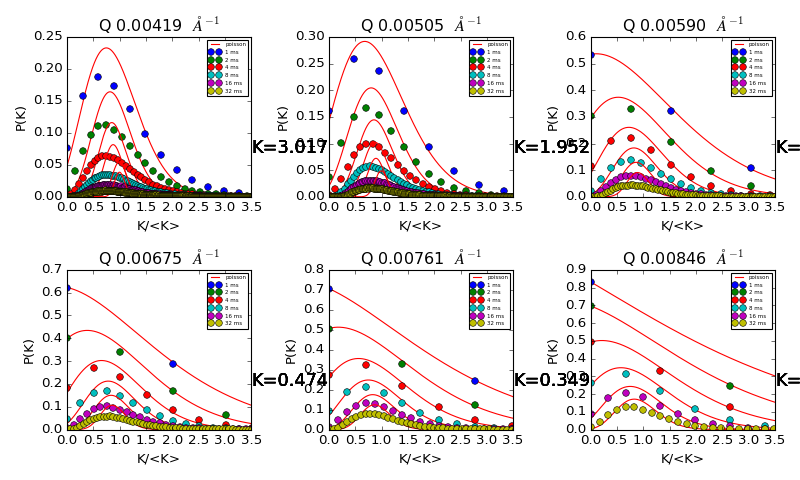

In [90]:
Kp_val = {}
sx = int(round(np.sqrt(num_rings)))
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
fig = plt.figure(figsize=(10,6))
plt.title('uid= %s'%uid+" Fitting with Poission Function", fontsize=20, y=1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])


for i in range(num_rings):
    Kp_val[i] = []
    for j in range(  6 ):
        roi = get_roi(data=spe_cts_all[j, i], threshold=1e-8)   
        
        # find the best value for K from fitting  
        result_p = p_mod.fit(spe_cts_all[j, i][roi],
                             bin_values=bin_edges[j, i][:-1][roi],
                             K=K_mean[i]*2**j)  
        
        Kp_val[i].append(result_p.best_values['K'])
        axes = fig.add_subplot(sx, sy, i+1 )
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")
        
        #  Using the best K value interpolate and get more values for fitting curve
        fitx_ = np.linspace(0, max(Knorm_bin_edges[j, i][:-1]), 10000 )  # these x values to plot      
        fitx = np.linspace(0, max(bin_edges[j, i][:-1]), 10000 )     # these x values for interpolation    
        fity = poisson_dist(fitx, Kp_val[i][j]  ) 
        
        if j == 0:
            art, = axes.plot(fitx_, fity, '-r', label="poisson")
        else:
            art, = axes.plot(fitx_, fity, '-r') 
            
 
        art, = axes.plot( Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], 'o',
                     label=str(time_steps[j])+" ms")
        axes.set_xlim(0, 3.5)           
        # Annotate the best K values on the plot    
        axes.annotate(r'K='+'%.3f'%(Kp_val[i][0]), xy=(1, 0.25),
                      xycoords='axes fraction', fontsize=16,
                      horizontalalignment='best', verticalalignment='best')
        
        axes.set_title("Q "+ '%.5f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend(loc='best', fontsize = 5)
plt.show()
fig.tight_layout()  

## Get the contast factor of detected signals is 1/M

$ \beta = 1/M $

In [128]:
contrast_factor = np.zeros((num_rings, num_times))

for i in range(num_rings):
    for j in range(num_times):
        contrast_factor[i, j] =  1/M_val[i][j]
#contrast_factor 

In [129]:
contrast_factor[0, :]

array([ 0.20145751,  0.19958302,  0.19866969,  0.19844628,  0.19822649,
        0.19642433,  0.19127878,  0.17949567,  0.16201641,  0.13768049,
        0.12513516,  0.11125914,  0.08741742,  0.02835894])

In [130]:
times = np.array( time_steps ) * exposuretime

<IPython.core.display.Javascript object>


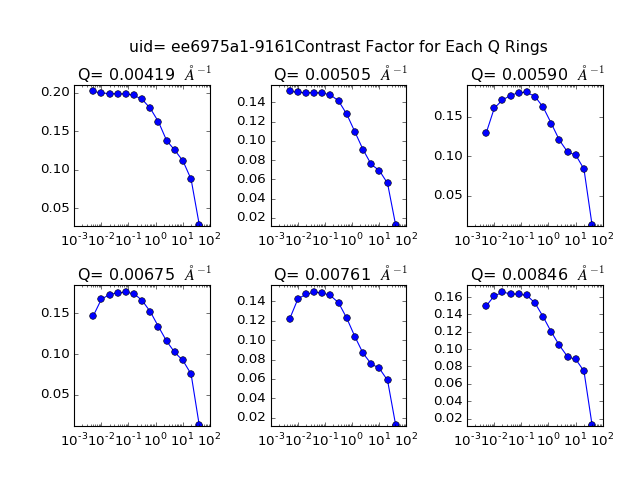

In [131]:
 
sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
#fig = plt.figure(figsize=(14, 10))
fig = plt.figure()
plt.title('uid= %s'%uid + "Contrast Factor for Each Q Rings", fontsize=14, y =1.08)  
plt.axis('off')
for sn in range(num_rings):
    ax = fig.add_subplot(sx, sy, sn+1 ) 
    y= contrast_factor[sn, :]   
    #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    ax.semilogx(times, y, "-o", 
                label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$') 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y)*.95, max(y[1:]) *1.05])
              
 
fig.tight_layout() 

### get fit of contrast factor

<IPython.core.display.Javascript object>


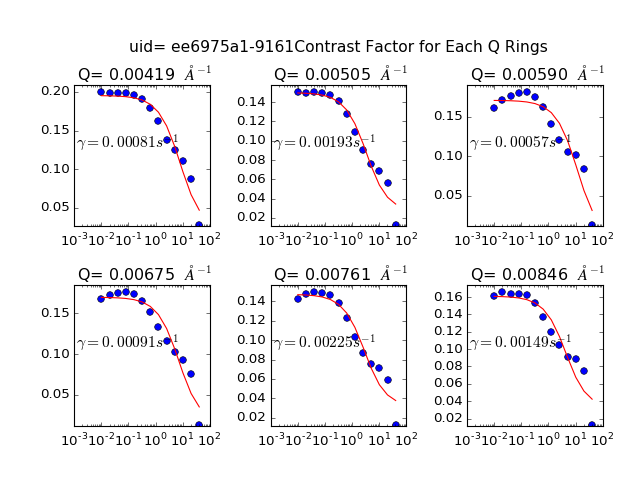

In [132]:
relax_rate = []

sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
#fig = plt.figure(figsize=(14, 10))
fig = plt.figure()
plt.title('uid= %s'%uid + "Contrast Factor for Each Q Rings", fontsize=14, y =1.08)  
plt.axis('off')
for sn in range(num_rings):
    ax = fig.add_subplot(sx, sy, sn+1 )
    
    time_steps_ = time_steps[1:]
    times_ = times[1:]
    y= contrast_factor[sn, 1:]  
    result_dc = dc_mod.fit(y, times=time_steps_,
                           relaxation_rate=1.0, contrast_factor=0.78, cf_baseline=0)
    relax_rate.append(result_dc.best_values['relaxation_rate'])
 
    #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    ax.semilogx(times_, y, "o", 
                label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    ax.semilogx(times_, result_dc.best_fit, '-r')
 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y)*.95, max(y[1:]) *1.05])
    txts = r'$\gamma$' + r'$ = %.5f$'%(relax_rate[sn]) +  r'$ s^{-1}$'
    ax.text(x =0.015, y=.55, s=txts, fontsize=14, transform=ax.transAxes)              
 
fig.tight_layout() 

In [133]:
relax_rate

[0.00081295629223235278,
 0.0019273773591229248,
 0.00056890650974488941,
 0.00090829867326046114,
 0.0022487366666977021,
 0.0014877534004996843]

<IPython.core.display.Javascript object>


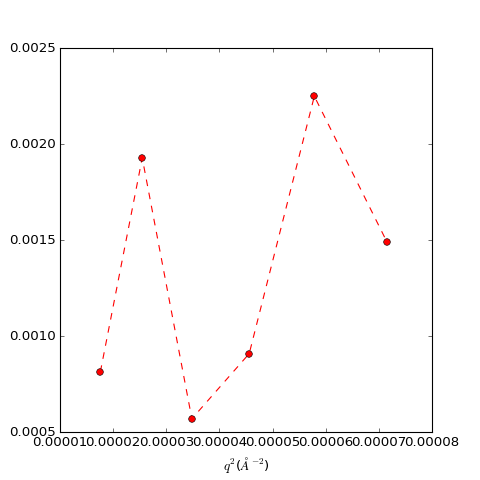

In [134]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(q_ring_center**2, relax_rate, 'ro', ls='--')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

In [135]:
D0 = np.polyfit(q_ring_center**2, relax_rate, 1)
gmfit = np.poly1d(D0)
print ('The fitted diffusion coefficient D0 is:  %.2E'%D0[0]  +  r'$\AA^{-2}$')

The fitted diffusion coefficient D0 is:  1.26E+01$\AA^{-2}$


<IPython.core.display.Javascript object>


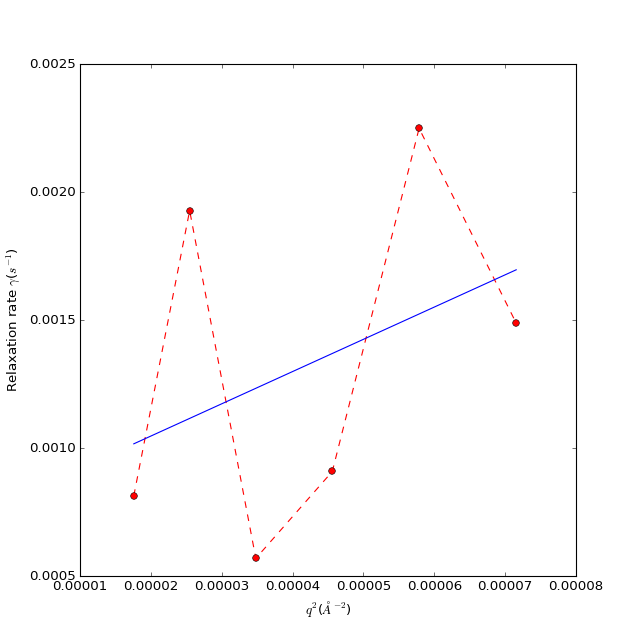

In [136]:
fig, ax = plt.subplots(figsize=(8, 8) )
ax.plot(q_ring_center**2, relax_rate, 'ro', ls='--')
ax.plot(q_ring_center**2,  gmfit(q_ring_center**2),  ls='-')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

## A comparision with xpcs results

In [126]:
tg2 = np.loadtxt(  path + 'g2_%s-%s--%s.txt'%(uid,good_start, good_end))
lags, g2 = tg2[:,0], tg2[:,1:]

<IPython.core.display.Javascript object>


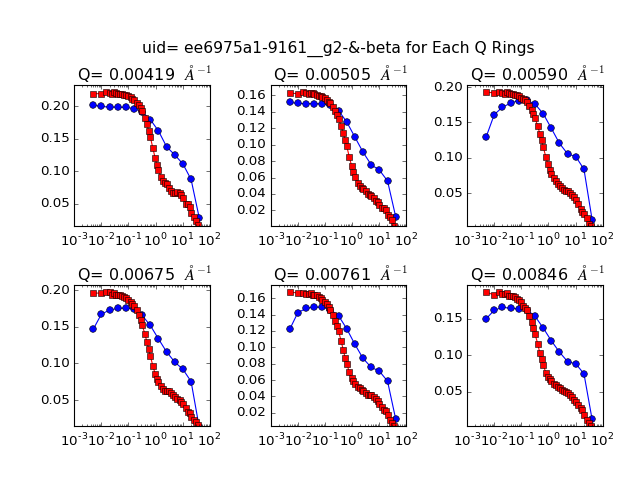

In [143]:
sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
#fig = plt.figure(figsize=(14, 10))
fig = plt.figure()
plt.title('uid= %s'%uid + "__g2-&-beta for Each Q Rings", fontsize=14, y =1.08)  
plt.axis('off')
for sn in range(num_rings):
    ax = fig.add_subplot(sx, sy, sn+1 ) 
    y= contrast_factor[sn, :]   
    #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    ax.semilogx(times, y, "-bo", 
                label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$') 
    
    y2=g2[:, sn]
    ax.semilogx(lags, y2 -1 , '-rs', markersize=6) 
    
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y2-1)*.95, max(y2[1:]-1) *1.05])
              
 
fig.tight_layout() 